In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras_tuner as kt
import pickle

# custom classes for cross validation and scoring
import cross_validation
import performance_metrics

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [2]:
data = pd.read_csv(r"../data/processed_data/complete_data.csv", index_col=0)


In [3]:
# split into features
x = data.drop(["TARGET"], axis=1)
y = data.filter(["TARGET"], axis=1)
y = y.values.reshape(y.shape[0])

# split dataset for hyperparameter tuning and kfold
split = 0.5
hp_x, hp_y = x[:int(len(x) * split)], y[:int(len(y) * split)] # hyperparameter set
kf_x, kf_y = x[int(len(x) * split):], y[int(len(y) * split):] # kfold set

hp_x.shape, hp_y.shape, kf_x.shape, kf_y.shape


((282686, 202), (282686,), (282686, 202), (282686,))

In [4]:
# scale the data for hyperparameter tuning
scaler = StandardScaler()
hp_x = scaler.fit_transform(hp_x)

In [5]:
def model_builder(hp):
    model = RandomForestClassifier(
        n_estimators=hp.Int("n_est", min_value=200, max_value=1000, step=100),
        max_depth=hp.Int("max_depth", 0, 100, 10),
        min_samples_leaf=hp.Choice("min_samples_leaf", [1, 2, 4]),
        min_samples_split=hp.Choice("min_samples_split", [2, 5, 10])
    )
    
    return model

In [7]:
project_name = "rf_v1"

tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective("score", "max"),
        max_trials=20
    ),
    hypermodel=model_builder,
    scoring=metrics.make_scorer(metrics.accuracy_score),
    cv=KFold(2, shuffle=True, random_state=7243),
    directory=f"../logs/rf/{project_name}",
    project_name=project_name
)

INFO:tensorflow:Reloading Tuner from ../logs/rf/rf_v1\rf_v1\tuner0.json


In [33]:
tuner.search(hp_x, hp_y)

Trial 2 Complete [00h 29m 08s]
score: 0.957875523125623

Best score So Far: 0.9591631715176676
Total elapsed time: 01h 19m 11s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
1000              |500               |n_est
40                |60                |max_depth
4                 |2                 |min_samples_leaf
5                 |5                 |min_samples_split



In [ ]:
# save the model architecture 
hpModel = tuner.get_best_models(1)[0]

with open(f"random_forest/{project_name}.pkl", "wb") as file:
    pickle.dump(hpModel, file)

In [6]:
# load the model    
# with open(f"random_forest/{project_name}.pkl", "rb") as file:
#     loaded_model = pickle.load(file)

loaded_model = RandomForestClassifier()

kfold = KFold(n_splits=5, shuffle=True, random_state=663)

# run cross validation for the model
cv = cross_validation.cross_val(np.array(kf_x), np.array(kf_y))
results, confusion_matrix = cv.run_validation(kfold=kfold, model=loaded_model, scaler=scaler)

Fold 1 completed
Fold 2 completed
Fold 3 completed
Fold 4 completed
Fold 5 completed
Validation Completed


In [9]:
# save to csv for easy viewing
results.to_csv(f"../results/random_forest/scores-{project_name}.csv")

results.round(4) * 100

,accuracy,precision,recall,f1,auc,fpr,fnr
Model,,,,,,,
1,95.81,99.82,91.81,95.65,95.82,0.08,4.10
2,95.80,99.80,91.88,95.68,95.85,0.09,4.10
3,95.94,99.76,92.06,95.76,95.92,0.11,3.94
4,95.90,99.79,92.04,95.76,95.92,0.10,4.00
5,95.96,99.73,92.14,95.79,95.95,0.12,3.92
Average,95.89,99.78,91.99,95.73,95.89,0.10,4.01


In [10]:
# save confusion matrix 
cm_df = pd.DataFrame(confusion_matrix)
cm_df.to_csv(f"../results/random_forest/cmdata-{project_name}.csv")

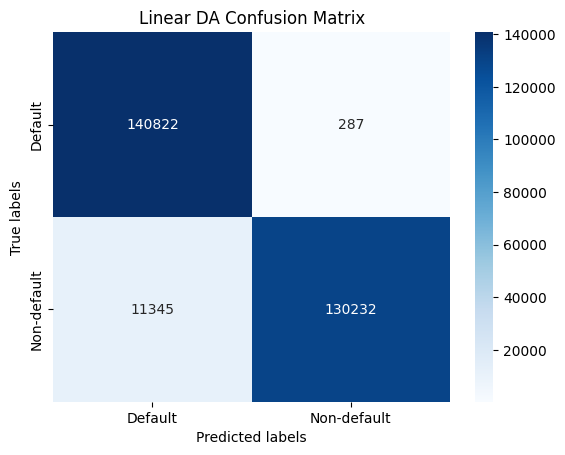

<Figure size 640x480 with 0 Axes>

In [11]:
fig = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')

# Set labels, title, and axis ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Forest Confusion Matrix')

tick_labels = ['Default', 'Non-default']
tick_positions = [0, 1]
plt.xticks(ticks=[pos + 0.5 for pos in tick_positions], labels=tick_labels)
plt.yticks(ticks=[pos + 0.5 for pos in tick_positions], labels=tick_labels)

# Show the plot
plt.show()

plt.tight_layout()

graph = fig.get_figure()
graph.savefig(f"../results/random_forest/cm-{project_name}.png")

In [ ]:
interpretation_model = loaded_model.fit(kf_x, kf_y)

with open(f"random_forest/{project_name}-interpretation.pkl", "wb") as file:
    pickle.dump(interpretation_model, file)